In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt 
from scipy import interpolate
import pandas as pd
import random
import numpy as np
import os 
import math
import torch
torch.set_default_dtype(torch.float)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import torch
import torch.nn as nn
import mads_dl


# load the data
def load_data():
    path_list = []
    cwd = Path(os.getcwd())
    print(f'Working Dir: {cwd}')
    data_path = os.path.join(cwd.parent, 'Data')

    print(f'Path: {data_path}')
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('FA_20231113_2H_yeast_Pyruvate-d3_1.csv'):
                file_path = os.path.join(root, file)
                path_list.append(file_path)
    return path_list


path_list = load_data()
print(path_list)

Working Dir: d:\Dokumente\MoinCC-AI4metabolomics\NMRQNet
Path: d:\Dokumente\MoinCC-AI4metabolomics\Data
['d:\\Dokumente\\MoinCC-AI4metabolomics\\Data\\FA_20231113_2H_yeast_Pyruvate-d3_1.csv']


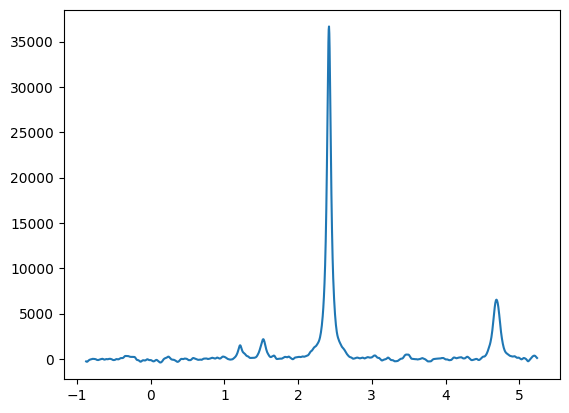

In [2]:
for i in range(len(path_list)):
    df = pd.read_csv(path_list[i])
    df['sum'] = df.iloc[:,1:].sum(axis=1)

    x = df.iloc[:,0]
    y = df.iloc[:, 1]

    #print(df.shape)

    plt.plot(x,y)


plt.show()

## Generating synthetic Data for - FA_20231113_2H_yeast_Pyruvate-d3_1.csv

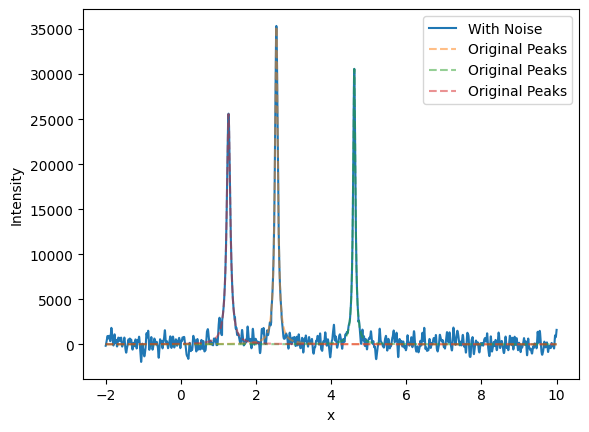

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Lorentzian function
def lorentzian(x, x0, gamma, height):
    return height * (gamma**2 / ((x - x0)**2 + gamma**2))


def generate_random_spectrum(peak_list):
    # Generate random spectrum with Lorentzian peaks
    x = np.linspace(-2, 10, 10000)  # x range
    y = np.zeros_like(x)          # initialize y as zeros
    mask = np.zeros_like(x)       # mask to identify peak regions

    # Add random Lorentzian peaks
    #np.random.seed(0)
    
    lorenz_curves = []
    for peak_pos in peak_list:
        x0 = peak_pos + np.random.uniform(-0.1, 0.1)
        #print(x0) 
        gamma = np.random.uniform(0.01, 0.1)  # Random width (gamma)
        height = np.random.uniform(0, 40000)  # Random height
        peak = lorentzian(x, x0, gamma, height)
        y += peak

        # Create a mask to identify regions near the peaks (exclude noise here)
        mask += peak > (0.1 * height)  # Masking regions where peak height is significant

        # Append all Original Lorenz Cuves to the list
        lorenz_curves.append(peak)

    # Add noise only outside the peak regions
    random_noise_level = np.random.uniform(100, 5000)
    noise = np.random.normal(10, random_noise_level, 10000)

    # smooth the noise with gaussian filter
    noise = gaussian_filter1d(noise, 10)
        
    y_noisy = y + noise * (mask == 0)  # Add noise only where mask is 0 (outside peaks)

    return x, y_noisy, np.array(lorenz_curves)


# ----

#peak_list = [2.323, 4.7, 1.201]
pyruvate_list = [2.468, 4.7, 1.2261]
x, y_noisy, lorenz_curves = generate_random_spectrum(pyruvate_list)

# Plot the result
plt.plot(x, y_noisy, '-', label="With Noise")

for lorenz in lorenz_curves:
    plt.plot(x, lorenz, '--', label="Original Peaks", alpha=0.5)  
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()
plt.show()


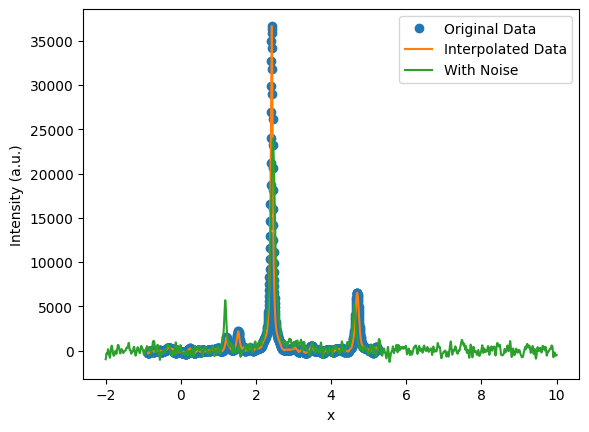

In [4]:



def interpolate_to_shape(x_original, y_original, spectrum_lenth=10000):
    """_summary_

    # Originaldaten
    y_original = df.iloc[:, 1]
    x_original = df.iloc[:, 0]

    Args:
        df (_type_): _description_
    """


    # Neue x-Werte (stellen Sie sicher, dass diese innerhalb des Bereichs von x_original liegen)
    x_new = np.linspace(x_original.min(), x_original.max(), spectrum_lenth)

    # Interpolierte Daten
    interpolated_data = interpolate.interp1d(x_original, y_original, kind='linear')(x_new)

    return x_new, interpolated_data



# X_val & y_val
x_original = df.iloc[:, 0]
y_original = df.iloc[:, 1]

x_new, interpolated_data = interpolate_to_shape(x_original, y_original)

# X_train & y_train
pyruvate_list = [2.468, 4.7, 1.2261]
x, y_noisy, lorenz_curves = generate_random_spectrum(pyruvate_list)



plt.plot(x_original, y_original, 'o', label='Original Data')
plt.plot(x_new, interpolated_data, '-', label='Interpolated Data')

plt.plot(x, y_noisy, label="With Noise")
plt.xlabel('x')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.show()

# Generate training Dataset 

In [5]:

num_samples = 1000

x_data = []
y_data = []
lorenzes = []
for i in range(num_samples):
    # X_train & y_train
    pyruvate_list = [2.468, 4.7, 1.2261]
    x, y_noisy, lorenz_curves = generate_random_spectrum(pyruvate_list)
    x_data.append(x)
    y_data.append(y_noisy)
    lorenzes.append(lorenz_curves)


# Umwandeln der Listen in NumPy-Arrays
x_data = np.array(x_data)
y_data = np.array(y_data)
lorenzes = np.array(lorenzes)

# Umwandeln der NumPy-Arrays in Tensoren
x_data = torch.tensor(x_data)
y_data = torch.tensor(y_data)
lorenzes = torch.tensor(lorenzes)

# Überprüfen der Formen
print(f"x_data shape: {x_data.shape}")
print(f"y_data shape: {y_data.shape}")
print(f"lorenzes shape: {lorenzes.shape}")
print('\n')
# Verwenden von torch.unsqueeze, um eine Dimension hinzuzufügen
x_data_unsqueezed = torch.unsqueeze(x_data, 1)  # Form wird (10, 1, 100, 10000)
x_data_unsqueezed = torch.unsqueeze(x_data_unsqueezed, 2)  # Form wird (10, 1, 1, 10000)
lorenzes_unsqueezed = torch.unsqueeze(lorenzes, 2)  # Form wird (10, 3, 1, 10000)

# Überprüfen der Formen nach dem Hinzufügen der Dimensionen
print(f"x_data_unsqueezed shape: {x_data_unsqueezed.shape}")
print(f"lorenzes_unsqueezed shape: {lorenzes_unsqueezed.shape}")
print('\n')

# Verwenden von torch.cat, um die Tensoren zu verbinden
data = torch.cat((x_data, y_data), dim=0)  # Form wird (20, 100, 10000)
target = torch.cat((x_data_unsqueezed, lorenzes_unsqueezed), dim=1)  # Form wird (10, 4, 100, 10000)
target = target.squeeze(2)  # Form wird (10, 4, 10000)
# Überprüfen der Formen der resultierenden Tensoren
print(f"data shape: {data.shape}")
print(f"target shape: {target.shape}")



x_data shape: torch.Size([1000, 10000])
y_data shape: torch.Size([1000, 10000])
lorenzes shape: torch.Size([1000, 3, 10000])


x_data_unsqueezed shape: torch.Size([1000, 1, 1, 10000])
lorenzes_unsqueezed shape: torch.Size([1000, 3, 1, 10000])


data shape: torch.Size([2000, 10000])
target shape: torch.Size([1000, 4, 10000])


In [6]:
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Überprüfen der Dimensionen der Tensoren
print(f"data shape: {data.shape}")
print(f"target shape: {target.shape}")

# data shape: torch.Size([200, 10000])
# target shape: torch.Size([100, 4, 10000])
shape = num_samples *2
target = target.reshape(shape, -1, 10000)   # torch.Size([200, 2, 10000])

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=0.4,
                                                    shuffle=True,
                                                    random_state=1)

# Skalieren der Daten
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Skalieren der X-Daten
X_train_sc = x_scaler.fit_transform(X_train)
X_test_sc = x_scaler.transform(X_test)

# Umformen der y-Daten für das Skalieren
y_train_reshaped = y_train.reshape(-1, y_train.shape[-1])
y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])

# Skalieren der y-Daten
y_train_sc = y_scaler.fit_transform(y_train_reshaped)
y_test_sc = y_scaler.transform(y_test_reshaped)

# Zurückformen der y-Daten in die ursprüngliche Form
y_train_sc = y_train_sc.reshape(y_train.shape)
y_test_sc = y_test_sc.reshape(y_test.shape)

# Konvertieren in Tensoren
X_train_tensor = torch.Tensor(X_train_sc)
X_test_tensor = torch.Tensor(X_test_sc)
y_train_tensor = torch.Tensor(y_train_sc)
y_test_tensor = torch.Tensor(y_test_sc)

# Überprüfen der Tensoren
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")

data shape: torch.Size([2000, 10000])
target shape: torch.Size([1000, 4, 10000])
X_train_tensor shape: torch.Size([1200, 10000])
X_test_tensor shape: torch.Size([800, 10000])
y_train_tensor shape: torch.Size([1200, 2, 10000])
y_test_tensor shape: torch.Size([800, 2, 10000])


## Implementing Multilayer Network

In [7]:
print(f"Verwende Gerät: {device}")

criterion = torch.nn.MSELoss().to(device)
learning_rate=0.01
epochs=1000

# Daten auf die GPU verschieben
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# print shapes
print(f'X_train_tensor shape: {X_train_tensor.shape}')
print(f'y_train_tensor shape: {y_train_tensor.shape}')
print(f'X_test_tensor shape: {X_test_tensor.shape}')
print(f'y_test_tensor shape: {y_test_tensor.shape}')


# MultiLayerPerceptron-Modell
import torch.nn as nn
import torch.optim as optim

class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MultiLayerPerceptron, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size*2)
        self.hidden2 = nn.Linear(hidden_size*2, hidden_size)
        self.hidden3 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()
        
    
    def forward(self, x):
        out = self.activation(self.hidden1(x))
        out = self.activation(self.hidden2(out))
        out = self.activation(self.hidden3(out))
        out = self.output(out)
        return out

# Modell initialisieren
input_size = 10000
hidden_size = 500
output_size = 2 * 10000  # Da wir 3 Targets mit 10000 Features haben
model = MultiLayerPerceptron(input_size, hidden_size, output_size).to(device)

# Loss und Optimizer
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training des Modells
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    outputs = outputs.view(-1, 2, 10000)  # Zurückformen der Ausgabe
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch: {epoch+1}, loss: {loss.item():.5f}')

# Testen des Modells
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = y_pred.view(-1, 2, 10000)  # Zurückformen der Ausgabe
    print(f'Predicted shape: {y_pred.shape}')

# Vorhersagen auf der GPU durchführen und dann auf die CPU verschieben
def predict(model, data):
    model.eval()
    with torch.no_grad():
        return model(data)




Verwende Gerät: cuda
X_train_tensor shape: torch.Size([1200, 10000])
y_train_tensor shape: torch.Size([1200, 2, 10000])
X_test_tensor shape: torch.Size([800, 10000])
y_test_tensor shape: torch.Size([800, 2, 10000])
Epoch: 100, loss: 0.01513
Epoch: 200, loss: 0.01466
Epoch: 300, loss: 0.01558
Epoch: 400, loss: 0.01452
Epoch: 500, loss: 0.01406
Epoch: 600, loss: 0.01500
Epoch: 700, loss: 0.01459
Epoch: 800, loss: 0.01438
Epoch: 900, loss: 0.01475
Epoch: 1000, loss: 0.01172
Predicted shape: torch.Size([800, 2, 10000])


In [8]:
# Use a dataframe to collect general evaluation results
results = pd.DataFrame()

# We will reuse this function. Hence we copy it to mads_dl.py
def add_regression_eval(results, algorithm, y_train, y_train_pred, y_test, y_test_pred, num_params):
    '''
    Create a table with evaluation results
    of a regression experiment
    '''
    for dataset, actual, predicted in zip(("train", "test"), (y_train, y_test), (y_train_pred, y_test_pred)):
        mse=mean_squared_error(actual, predicted)
        results= pd.concat([results, pd.DataFrame([{
            "algorithm": algorithm, 
            "dataset": dataset,
            "MSE": mse,
            "RMSE": math.sqrt(mse),
            "MAE": mean_absolute_error(actual, predicted),
            "MAPE": mean_absolute_percentage_error(actual, predicted)*100, # implemented is relative to 1 not to 100
            "params": num_params
        }])], ignore_index=True)   
    return results


In [9]:
print(f'X_train_tensor shape: {X_train_tensor.shape}')
print(f'X_test_tensor shape: {X_train_tensor.shape}')
print(f'y_train_tensor shape: {y_train_tensor.shape}')
print(f'y_test_tensor shape: {y_test_tensor.shape}')
print('\n')

# Vorhersagen und Rückskalierung
y_train_pred = predict(model, X_train_tensor).view(-1,2, 10000).cpu().detach().numpy()
y_test_pred = predict(model, X_train_tensor).view(-1,2, 10000).cpu().detach().numpy()

print(f'X_train_tensor shape: {X_train_tensor.shape}')
print(f'X_test_tensor shape: {X_train_tensor.shape}')
# Rückskalieren der Vorhersagen
y_train_pred_reshaped = y_train_pred.reshape(-1, 10000)
y_test_pred_reshaped = y_test_pred.reshape(-1, 10000)
print(f'y_train_pred_reshaped shape: {y_train_pred_reshaped.shape}')
y_train_pred_rescaled = y_scaler.inverse_transform(y_train_pred_reshaped)
y_test_pred_rescaled = y_scaler.inverse_transform(y_test_pred_reshaped)

X_train_tensor shape: torch.Size([1200, 10000])
X_test_tensor shape: torch.Size([1200, 10000])
y_train_tensor shape: torch.Size([1200, 2, 10000])
y_test_tensor shape: torch.Size([800, 2, 10000])


X_train_tensor shape: torch.Size([1200, 10000])
X_test_tensor shape: torch.Size([1200, 10000])
y_train_pred_reshaped shape: (2400, 10000)


In [10]:
data.shape, target.shape

(torch.Size([2000, 10000]), torch.Size([2000, 2, 10000]))

y_train_tensor shape: torch.Size([1200, 2, 10000])
(800, 3, 10000)


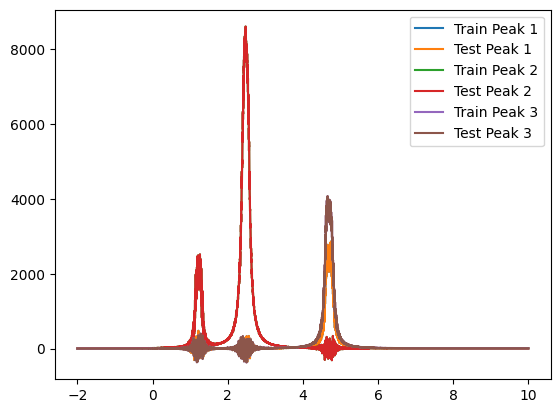

In [16]:
print(f'y_train_tensor shape: {y_train_tensor.shape}')
y_train_pred_rescaled = y_train_pred_rescaled.reshape(-1, 3, 10000)
y_test_pred_rescaled = y_test_pred_rescaled.reshape(-1, 3, 10000)

#y_test_pred_rescaled = y_test_pred_rescaled.reshape(-1, 3, 10000)
print(y_train_pred_rescaled.shape)

x_original = x_data[1]
for i in range(3):
    y_plot = y_train_pred_rescaled[0,i,:]
    plt.plot(x_original, y_plot, label=f'Train Peak {i+1}')
    y_plot = y_test_pred_rescaled[0,i,:]
    plt.plot(x_original, y_plot, label=f'Test Peak {i+1}')

#x_new, interpolated_data = interpolate_to_shape(x_original, y_original)
plt.legend()
plt.show()




# Test on Data

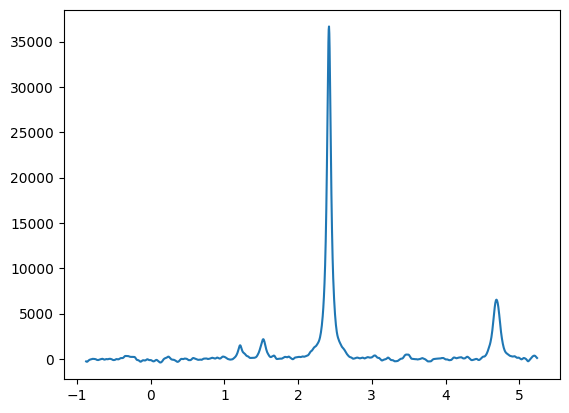

In [12]:

df = pd.read_csv(path_list[0]) 
df['sum'] = df.iloc[:,1:].sum(axis=1)
x = df.iloc[:,0]
y = df.iloc[:, 1]
plt.plot(x,y)
plt.show()

In [13]:
df = pd.read_csv(path_list[0]) 
df['sum'] = df.iloc[:,1:].sum(axis=1)
x = df.iloc[:,0]
y = df.iloc[:, 1]

# apllying interpolation
x, y = interpolate_to_shape(x, y)

x = torch.tensor(x).to('cpu')
y = torch.tensor(y).to('cpu')
data = torch.cat((x, y), dim=0)

# umformen der daten für das scalieren
data = data.reshape(-1, 10000)
print(data.shape)
# Skalieren der Daten
data = x_scaler.transform(data)

# Zurückformen der Daten in die ursprüngliche Form
data = data.reshape(data.shape)

# Konvertieren in Tensoren
data = torch.Tensor(data).to(device)
data = data.reshape(-1, 10000)

pred = predict(model, data).view(-1,2, 10000).cpu().detach().numpy()

pred = pred.reshape(-1, 10000)

print(f'y_train_pred_reshaped shape: {y_train_pred_reshaped.shape}')

pred = y_scaler.inverse_transform(pred)


x_pred = pred[0,:]
y_pred = pred[1:,:]
print(y_pred.shape)





torch.Size([2, 10000])
y_train_pred_reshaped shape: (2400, 10000)
(3, 10000)


y_pred shape after reshaping: (3, 10000)


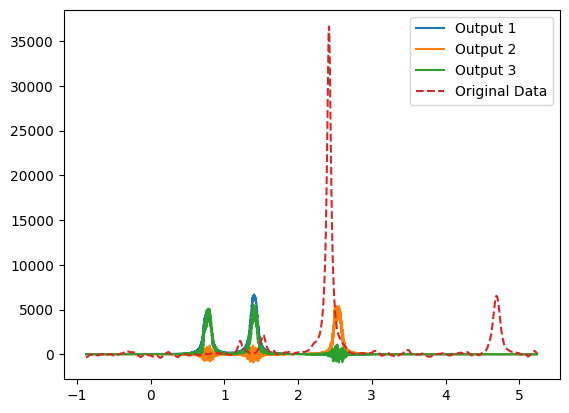

In [18]:

# Überprüfen der neuen Form
print(f'y_pred shape after reshaping: {y_pred.shape}')

# Plotten der Daten
for i in range(3):
    y_pred_sample = y_pred[i, :]  # Zugriff auf die erste Probe und die i-te Ausgabe
    plt.plot(x, y_pred_sample, label=f'Output {i+1}')
plt.plot(x, y, label='Original Data', linestyle='--')

plt.legend()
plt.show()